Data madness setup

In [2]:
#Imports
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


In [3]:
# Load 
complete_data = pd.read_csv("athlete_events.csv")

print(complete_data.columns.values)
#1. ID - Row numbers
#2. Name - Athlete's name
#3. Sex - M or F
#4. Age - Integer
#5. Height - In centimeters
#6. Weight - In kilograms
#7. Team - Team name
#8. NOC - National Olympic Committee 3-letter code
#9. Games - Year and season
#10. Year - Integer
#11. Season - Summer or Winter
#12. City - Host city
#13. Sport - Sport
#14. Event - Event
#15. Medal - Gold, Silver, Bronze, or NA
complete_data.head(3)

['ID' 'Name' 'Sex' 'Age' 'Height' 'Weight' 'Team' 'NOC' 'Games' 'Year'
 'Season' 'City' 'Sport' 'Event' 'Medal']


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN


In [4]:
# Functions

# Medal convertion to numeric columns
def convert_medals(data):
    types = ['', 'Gold', 'Silver', 'Bronze']
    
    cat_type = CategoricalDtype(categories=types)
    
    data['Medal'] = data['Medal'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='mdl',
                          columns=['Medal'], 
                          drop_first=True)
    
    return data

In [5]:
# Clean data

# Sort by olympic event (years) to make it easier to interpret
complete_data = complete_data.sort_values('Games')

# Replacing all NaN values with 0
complete_data = complete_data.fillna(0)

# Convert medals to numerical values
complete_data = convert_medals(complete_data)

# Ideas:
# Ethics -> Electronic clocks only started since 1936 (we could do something with that)

complete_data.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,mdl_Gold,mdl_Silver,mdl_Bronze
132219,66542,Leonidas Lanngakis,M,0.0,0.0,0.0,Greece,GRE,1896 Summer,1896,Summer,Athina,Shooting,"Shooting Men's Free Rifle, Three Positions, 30...",0,0,0
214353,107613,Carl Schuhmann,M,26.0,159.0,70.0,Germany,GER,1896 Summer,1896,Summer,Athina,Gymnastics,Gymnastics Men's Rings,0,0,0
214352,107613,Carl Schuhmann,M,26.0,159.0,70.0,Germany,GER,1896 Summer,1896,Summer,Athina,Gymnastics,"Gymnastics Men's Horizontal Bar, Teams",1,0,0
24682,12929,John Mary Pius Boland,M,25.0,0.0,0.0,Great Britain,GBR,1896 Summer,1896,Summer,Athina,Tennis,Tennis Men's Singles,1,0,0
214351,107613,Carl Schuhmann,M,26.0,159.0,70.0,Germany,GER,1896 Summer,1896,Summer,Athina,Wrestling,"Wrestling Men's Unlimited Class, Greco-Roman",1,0,0


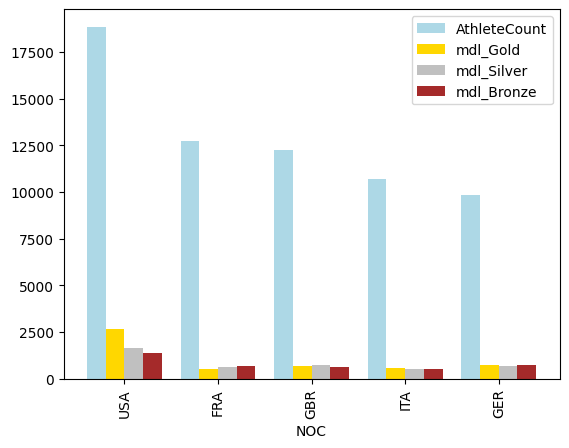

In [6]:
# Medals per country Vs Competing athletes per country
Medals = complete_data[['NOC', 'mdl_Gold', 'mdl_Silver', 'mdl_Bronze']].groupby(['NOC'], as_index=False).sum()

AthleteCount = complete_data['NOC'].value_counts()
AthleteCount = AthleteCount.sort_index()

Medals.insert(1, column='AthleteCount', value=AthleteCount.values)

# Get top 5 in Athlete count and top 5 in Medals
TopAc = Medals.sort_values('AthleteCount', ascending=False).head(5)
TopGold = Medals.sort_values('mdl_Gold', ascending=False).head(5)
TopSilver = Medals.sort_values('mdl_Silver', ascending=False).head(5)
TopBronze = Medals.sort_values('mdl_Bronze', ascending=False).head(5)


fig, ax = plt.subplots()
TopAc.set_index('NOC').plot(kind='bar', ax=ax, width=0.8, color=['lightblue', 'gold', 'silver', 'brown'])
#TopGold.set_index('NOC').plot(kind='bar', ax=ax2, width=0.8, color=['lightblue', 'gold', 'silver', 'brown'])
#TopSilver.set_index('NOC').plot(kind='bar', ax=ax3, width=0.8, color=['lightblue', 'gold', 'silver', 'brown'])
#TopBronze.set_index('NOC').plot(kind='bar', ax=ax4, width=0.8, color=['lightblue', 'gold', 'silver', 'brown'])
plt.show()



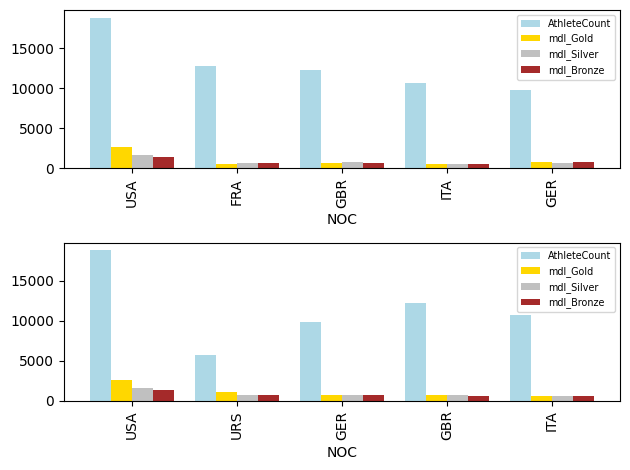

In [31]:
# Amount of athletes vs Amount of medals

fig, (ax1, ax2) = plt.subplots(2)
ax1 = TopAc.set_index('NOC').plot(kind='bar', ax=ax1, width=0.8, color=['lightblue', 'gold', 'silver', 'brown']).legend(fontsize='x-small')
ax2 = TopGold.set_index('NOC').plot(kind='bar', ax=ax2, width=0.8, color=['lightblue', 'gold', 'silver', 'brown']).legend(fontsize='x-small')
fig.tight_layout()
#ax3 = TopSilver.set_index('NOC').plot(kind='bar', ax=ax3, width=0.8, color=['lightblue', 'gold', 'silver', 'brown'])
#ax4 = TopBronze.set_index('NOC').plot(kind='bar', ax=ax4, width=0.8, color=['lightblue', 'gold', 'silver', 'brown'])


This graph represents the amount of athletes and the amount of medals a certain country has, during the entire olympics.
The USA is first in both graphs because they just have an absurd amount of athletes that compete.
A little bit further down the graph we can start to see the differences though, france for example has the 2nd highest amount of competing athletes,
but arent even in the top 5 when it comes to gold medals.

URS = Russian soviet union

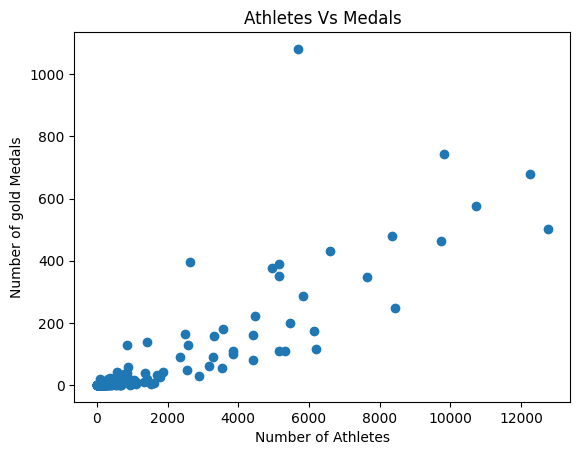

In [48]:
# Comparison plot for athletes vs medals

# Had to remove the USA due it being an extreme outlier
NoUsa = Medals[Medals['NOC'] != 'USA']

corr = NoUsa['AthleteCount'].corr(NoUsa['mdl_Gold'])

plt.scatter(NoUsa['AthleteCount'], NoUsa['mdl_Gold'])
plt.xlabel('Number of Athletes')
plt.ylabel('Number of gold Medals')
plt.title('Athletes Vs Medals')
plt.show()


Relation between amount of athletes vs gold medals does exist as expected, but it is not as strict as one might assume. There are some very high performing countries that do not have that many athletes competing. 

Soviet union era Russia (pre 1991) is a good example of this. (it is the upper dot in the middle) This however also brings an ethical question, because Russia has been accused of doping use on many occasions and has been banned from several competitions for this reason. Especially with the lenient  rules regarding doping use, pre 2000.

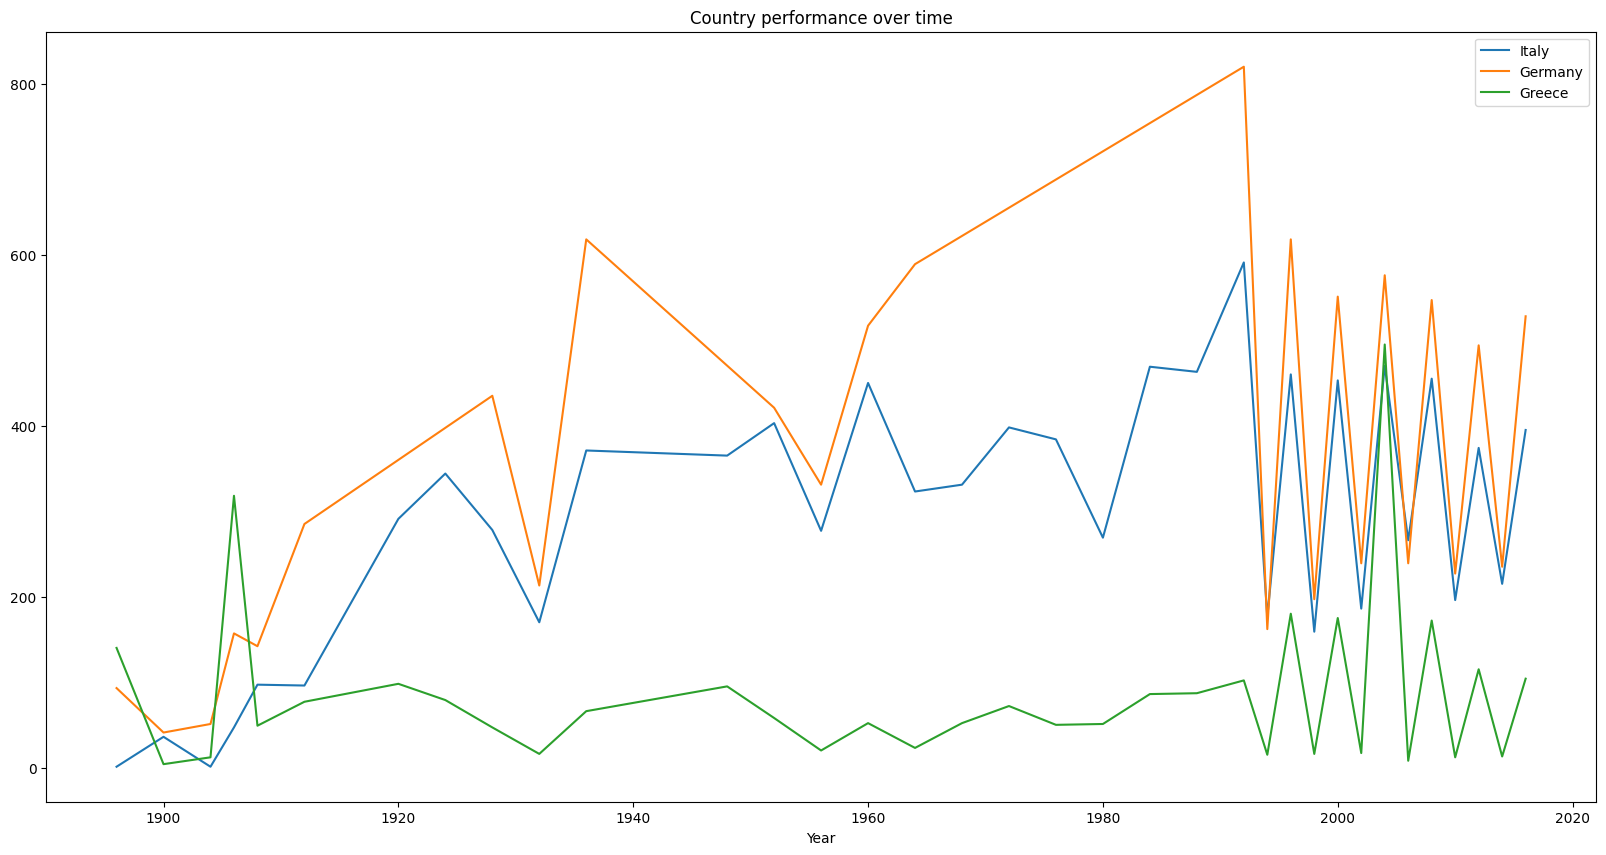

In [33]:
# Giulias section

# Italy performance over years , distinction between Winter and Summer season
ItalyOverTime_Winter = complete_data[(complete_data.Team == 'Italy') & (complete_data.Season == 'Winter')] 
ItalyOverTime_Summer= complete_data[(complete_data.Team == 'Italy') & (complete_data.Season == 'Summer')] 

part = ItalyOverTime_Winter.groupby('Year')['Team'].value_counts()
plt.figure(figsize=(20, 10))
part.loc[:,'Italy'].plot(label= "Winter")


part_summer=ItalyOverTime_Summer.groupby('Year')['Team'].value_counts()
part_summer.loc[:,'Italy'].plot(label= "Summer")

plt.title('Italy performance over time')
plt.legend()


In [ ]:
#Germany performance over years , distinction between Winter and Summer season
GermanyOverTime_Winter = complete_data[(complete_data.Team == 'Germany') & (complete_data.Season == 'Winter')] 
GermanyOverTime_Summer= complete_data[(complete_data.Team == 'Germany') & (complete_data.Season == 'Summer')] 

part = GermanyOverTime_Winter.groupby('Year')['Team'].value_counts()
plt.figure(figsize=(20, 10))
part.loc[:,'Germany'].plot(label= "Winter")


part_summer=GermanyOverTime_Summer.groupby('Year')['Team'].value_counts()
part_summer.loc[:,'Germany'].plot(label= "Summer")

plt.title('Germany performance over time')
plt.legend()


In [ ]:
# Italy/Germany/Greece performance over years 

ItalyOverTime = complete_data[(complete_data.Team == 'Italy')]
GermanyOverTime= complete_data[(complete_data.Team == 'Germany')]
GreeceOverTime=complete_data[(complete_data.Team == 'Greece')]

partItaly = ItalyOverTime.groupby('Year')['Team'].value_counts()
partGermany = GermanyOverTime.groupby('Year')['Team'].value_counts()
partGreece = GreeceOverTime.groupby('Year')['Team'].value_counts()

plt.figure(figsize=(20, 10))

partItaly.loc[:,'Italy'].plot(label= "Italy")
partGermany.loc[:,'Germany'].plot(label= "Germany")
partGreece.loc[:,'Greece'].plot(label= "Greece")


plt.title('Country performance over time')
plt.legend()
